## Proyecto del Día 13 - Juego de Navegación en un Laberinto

Este proyecto tiene como objetivo desarrollar un entorno de laberinto simple y aplicar un algoritmo de **Aprendizaje por Refuerzo** para enseñar a una IA a navegar desde un punto inicial hasta un objetivo.

Dada la naturaleza de este proyecto, considero que el algoritmo más adecuado para este tipo de probleas es **Q-Learning**, por su facilidad de implelentación y comprensión, su estabilidad y su relación entre la exploración y la explotación.

Por esa razón te propongo resolverlo usando ese algoritmo, aunque dejo a tu criterio si quieres resolverlo con otro algoritmo de tu elección. Siempre estaré a favor de que investigues, y expandas las habilidades propuestas por tu cuenta.

### Descripción del Laberinto:

El laberinto se representa como una matriz de dos dimensiones, donde cada elemento puede ser:
+ un camino libre (0)
+ un obstáculo (1)
+ el objetivo (G)

La tarea es desarrollar un agente que pueda aprender a encontrar el camino desde un punto de inicio hasta el objetivo evitando obstáculos.


### Creación del Laberinto

Debido a que el desafío de hoy es bastante complejo, y que el objetivo final no se trata de que sepas desarrollar laberintos, sino sistemas para resolverlos, voy a facilitar la tarea entregando en este cuaderno el código para generar nuestros laberintos.

Tu parte será la siguiente, que es diseñar y entrenar un modelo de Q-Learning para resolver el laberinto de la manera mpas eficiente, y luego mostrar una visualización sobre cómo lo ha hecho.

Te deseo toda la suerte del mundo, y sobre todo, que te diviertas de a montones.

In [3]:
# Librerías necesarias para todo el ejercicio
import numpy as np
import matplotlib.pyplot as plt
import random

In [4]:
# Función para crear el laberinto
def crear_laberinto(tamanio, porcentaje_paredes=20, inicio=(0, 0), meta=None):
    laberinto = np.zeros((tamanio, tamanio))
    numero_paredes = int((tamanio * tamanio) * porcentaje_paredes / 100)
    
    # Ubicar paredes
    for pared in range(numero_paredes):
        x, y = random.randint(0, tamanio-1), random.randint(0, tamanio-1)
        
        # Cuidar que inicio y meta no sean paredes
        if (x, y) != inicio and (meta is None or (x, y) != meta):
            laberinto[x, y] = 1
            
    # Ubicar la meta
    if meta:
        laberinto[meta] = 9  # Representa la meta con 9
    else:
        # Ubicar la meta aleatoriamente si no está especificado
        while True:
            x, y = random.randint(0, tamanio-1), random.randint(0, tamanio-1)
            if laberinto[x, y] == 0 and (x, y) != inicio:
                laberinto[x, y] = 9
                break
    
    return laberinto

In [5]:
# Función para visualizar el laberinto
def ver_laberinto(laberinto):
    plt.figure(figsize=(5, 5))
    plt.imshow(laberinto, cmap='hot', interpolation='nearest')
    plt.colorbar();

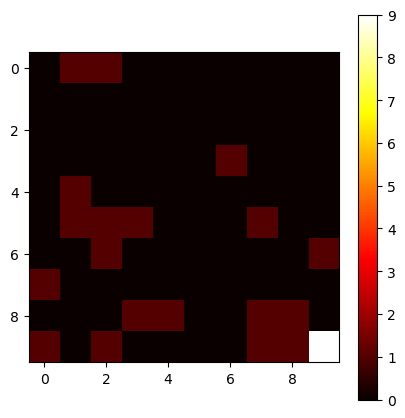

In [9]:
# Ejemplo de crear y mostrar laberintos
laberinto = crear_laberinto(10, 20, inicio=(0, 0), meta=(9, 9))
ver_laberinto(laberinto)

### Ahora te toca a ti

Lo que sigue es implementar todo el código para que un algoritmo de Q-Learning encuentre la manera más eficiente de llegar a la meta. Voy a dejarte los pasos que considero que son los necesarios para lograrlo

##### 1. Parámetros para el algoritmo Q-Learning

In [12]:
alpha = 0.1 #Nivel de Aprendizaje
gamma = 0.9 #Factor de descuento
epsilon = 0.1 #Variacion de exploracion
num_episodios = 500 #Cantidad de repeticiones

##### 2. Función para elegir acciones equilibrando entre explotación y exploración

In [15]:
def epsilon_codicioso(Q, estado, tamanio_estado):
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, 3)  # Suponemos 4 acciones posibles: arriba, abajo, izquierda, derecha
    else:
        return np.argmax(Q[estado])

##### 3. Función para simular la acción en el laberinto

In [18]:
def ejecutar_accion(estado, accion, laberinto, tamanio):
    fila, columna = divmod(estado, tamanio)
    if accion == 0 and fila > 0:  # arriba
        fila -= 1
    elif accion == 1 and fila < tamanio - 1:  # abajo
        fila += 1
    elif accion == 2 and columna > 0:  # izquierda
        columna -= 1
    elif accion == 3 and columna < tamanio - 1:  # derecha
        columna += 1
    
    siguiente_estado = fila * tamanio + columna
    if laberinto[fila, columna] == 1:
        recompensa = -100  # Penalización por golpear un muro
        siguiente_estado = estado  # El agente permanece en el mismo lugar si golpea un muro
        terminado = False
    elif laberinto[fila, columna] == 9:
        recompensa = 100  # Recompensa por alcanzar el objetivo
        terminado = True
    else:
        recompensa = -1  # Penalización menor por cada paso para fomentar soluciones más rápidas
        terminado = False
    return siguiente_estado, recompensa, terminado

##### 4. Función principal para ejecutar el algoritmo Q-Learning

In [21]:
def q_learning(laberinto, tamanio, inicio, meta):
    Q = np.zeros((tamanio * tamanio, 4))  # Inicializa la tabla Q para todos los estados y acciones
    for episodio in range(num_episodios):
        estado = inicio
        terminado = False
        
        while not terminado:
            accion = epsilon_codicioso(Q, estado, tamanio)
            siguiente_estado, recompensa, terminado = ejecutar_accion(estado, accion, laberinto, tamanio)
            Q[estado, accion] += alpha * (recompensa + gamma * max(Q[siguiente_estado]) - Q[estado, accion])
            estado = siguiente_estado
            
    return Q

##### 5. Función para convertir coordenadas a índice lineal

In [24]:
def index_posicion(posicion, tamanio):
    return posicion[0] * tamanio + posicion[1]

##### 6. Iniciar el laberinto y configurar el algoritmo Q-Learning

In [27]:
tamanio = 10
posicion_inicio = (0, 0)
posicion_meta = (9, 9)
laberinto = crear_laberinto(tamanio, 20, inicio=posicion_inicio, meta=posicion_meta)
inicio = index_posicion(posicion_inicio, tamanio)
meta = index_posicion(posicion_meta, tamanio)
valores_Q = q_learning(laberinto, tamanio, inicio, meta)

##### 7. Función para mostrar el aprendizaje del agente

In [30]:
def mostrar_ruta_aprendida(laberinto, Q, inicio, meta, tamanio):
    fila, columna = divmod(inicio, tamanio)
    ruta = [(fila, columna)]
    estado = inicio
    while estado != meta:
        accion = np.argmax(Q[estado])
        estado, _, _ = ejecutar_accion(estado, accion, laberinto, tamanio)
        fila, columna = divmod(estado, tamanio)
        ruta.append((fila, columna))
    
    # Mostrar el camino aprendido sobre el laberinto
    plt.figure(figsize=(5, 5))
    plt.imshow(laberinto, cmap='hot', interpolation='nearest')
    filas, columnas = zip(*ruta)
    plt.plot(columnas, filas, marker='o', color='c')
    plt.colorbar();

##### 8. Visualizar el resultado

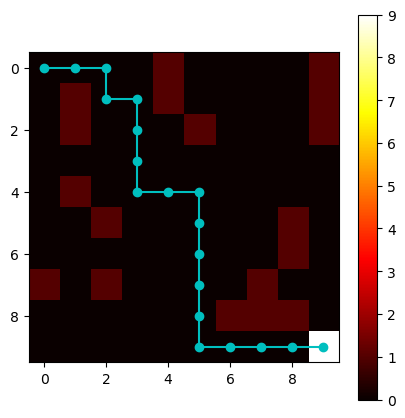

In [33]:
mostrar_ruta_aprendida(laberinto, valores_Q, inicio, meta, tamanio)
